In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import pandas as pd
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
plt.ion() # interactive mode 交互模式
plt.rcParams['figure.facecolor']=(1,1,1,1) # pycharm 绘图白底，看得清坐标

c:\program files\python37\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
c:\program files\python37\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
c:\program files\python37\lib\site-packages\numpy\.libs\libopenblas.TXA6YQSD3GCQQC22GEQ54J2UDCXDXHWN.gfortran-win_amd64.dll
  stacklevel=1)


In [2]:
data_transforms = {
    'train' : transforms.Compose([
        transforms.RandomResizedCrop(224), #随机裁剪，再resize
        transforms.RandomHorizontalFlip(), #随机水平翻转
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        # 3 个通道的 mean， std
    ]),
    'val':transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        # 3 个通道的 mean， std
    ])
}

data_path ='./data/hymenoptera_data'
img_dataset = {x : datasets.ImageFolder(os.path.join(data_path, x),transform=data_transforms[x])
               for x in ['train', 'val']}

In [3]:
dataloader = {x : torch.utils.data.DataLoader(img_dataset[x], batch_size=4,
                                              shuffle=True, num_workers=4)
              for x in ['train', 'val']}

dataset_sizes = {x: len(img_dataset[x]) for x in ['train', 'val']}
class_names = img_dataset['train'].classes
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

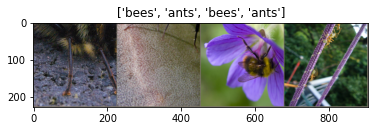

In [4]:
def show_img(inp, title=None):
    inp = inp.numpy().transpose((1,2,0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

inputs, classes = next(iter(dataloader['train']))

out = torchvision.utils.make_grid(inputs)
show_img(out, title=[class_names[x] for x in classes])

In [5]:
def train_model(model, loss_fn, optimizer, scheduler, num_epochs=25):
    starttime = time.time()
    best_model_w = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs-1))
        print('-'*12)
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train()
            else:
                model.eval()
            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloader[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                optimizer.zero_grad()
                with torch.set_grad_enabled(phase=='train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = loss_fn(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                running_loss += loss.item()*inputs.size(0)
                running_corrects += torch.sum(preds==labels.data)
            epoch_loss = running_loss/dataset_sizes[phase]
            epoch_acc = running_corrects/dataset_sizes[phase]
            print('{} Loss:{:.4f} Acc:{:.4f}'.format(phase, epoch_loss, epoch_acc))

            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_w = copy.deepcopy(model.state_dict())
    time_cost = time.time() - starttime
    print("训练花费时间：{:.0f}m {:.0f}s".format(time_cost//60, time_cost%60))
    print("最好的验证准确率：{:.4f}".format(best_acc))

    model.load_state_dict(best_model_w)
    return model

In [6]:
# 展示少量图片
def vis_model(model, num_imgs=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()
    with torch.no_grad():
        for i,(inputs,labels) in enumerate(dataloader['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_imgs//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('preds:{}'.format(class_names[preds[j]]))
                show_img(inputs.cpu().data[j])

                if images_so_far == num_imgs:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [7]:
model_finetune = models.resnet18(pretrained=True)
num_features = model_finetune.fc.in_features
model_finetune.fc = nn.Linear(num_features, 2)
model_finetune = model_finetune.to(device)

loss_fn = nn.CrossEntropyLoss()

optimizer_ft = optim.SGD(model_finetune.parameters(), lr=0.001, momentum=0.9)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [8]:
model_finetune = train_model(model_finetune, loss_fn, optimizer_ft, exp_lr_scheduler,num_epochs=25)
print(' ')

Epoch 0/24
------------
train Loss:0.6048 Acc:0.0000
val Loss:0.2746 Acc:0.0000
Epoch 1/24
------------
train Loss:0.6371 Acc:0.0000
val Loss:0.2396 Acc:0.0000
Epoch 2/24
------------
Traceback (most recent call last):
  File "C:\Users\mingm\AppData\Roaming\Python\Python37\site-packages\IPython\core\interactiveshell.py", line 3343, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-8-eef2f0d5ba14>", line 2, in <module>
    model_finetune = train_model(model_finetune, loss_fn, optimizer_ft, exp_lr_scheduler,num_epochs=25)
  File "<ipython-input-5-1d1bd964472c>", line 22, in train_model
    outputs = model(inputs)
  File "c:\program files\python37\lib\site-packages\torch\nn\modules\module.py", line 532, in __call__
    result = self.forward(*input, **kwargs)
  File "c:\program files\python37\lib\site-packages\torchvision\models\resnet.py", line 216, in forward
    return self._forward_impl(x)
  File "c:\program files\python37\lib\site-packages\torchv

c:\program files\python37\lib\site-packages\torch\optim\lr_scheduler.py:122: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



TypeError: object of type 'NoneType' has no len()